In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import plotly.graph_objects as go

# Importing machine learning models
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn import metrics

# Importing metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats

# Importing model selection utilities
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve

In [11]:
# Define adjusted R^2
def adjusted_r2(y_true, y_pred, n, p):
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

In [12]:
df = pd.read_csv('../data/processed/preprocessed_data.csv')

# log-transform highly skewed variables
df['log_price'] = np.log1p(df['price'])
df['log_host_listings'] = np.log1p(df['calculated_host_listings_count'])
df['log_avail365'] = np.log1p(df['availability_365'])

y = df['log_price']

# Drop y-var and any other variables derived from price
X = df.drop(["log_price", "price","total_cost_min_stay", "annual_potential_income", "min_potential_income", "availability_365", "calculated_host_listings_count"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [13]:
models = [('LR', LinearRegression()),
          ('KNN', KNeighborsRegressor()),
          ('RT', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("CatBoost", CatBoostRegressor(verbose=False))]

rmse_scores = []
r2_scores = []
mae_scores = []
mse_scores = []
execution_times = []

for name, regressor in models:
    start_time = time.time()

    # Fit the model
    regressor.fit(X_train, y_train)

    # Make predictions
    y_pred = regressor.predict(X_test)

    # Calculate RMSE
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    rmse_scores.append(rmse)
    
    # Calculate R^2 score
    r2 = metrics.r2_score(y_test, y_pred)
    r2_scores.append(r2)

    # Calculate MAE
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

    # Calculate MSE
    mse = metrics.mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

    # Calculate the execution time of the model
    execution_time = time.time() - start_time
    execution_times.append(execution_time)

    print(f"RMSE: {round(rmse, 4)} ({name})")
    print(f"R^2 Score: {round(r2, 4)} ({name})")
    print(f"MAE: {round(mae, 4)} ({name})")
    print(f"MSE: {round(mse, 4)} ({name})")
    print(f"Execution Time: {round(execution_time, 2)} seconds\n")

RMSE: 0.4759 (LR)
R^2 Score: 0.525 (LR)
MAE: 0.3464 (LR)
MSE: 0.2155 (LR)
Execution Time: 0.35 seconds

RMSE: 0.6392 (KNN)
R^2 Score: 0.2318 (KNN)
MAE: 0.4488 (KNN)
MSE: 0.3484 (KNN)
Execution Time: 1.48 seconds

RMSE: 0.6261 (RT)
R^2 Score: 0.2473 (RT)
MAE: 0.4246 (RT)
MSE: 0.3414 (RT)
Execution Time: 2.1 seconds

RMSE: 0.4458 (RF)
R^2 Score: 0.6232 (RF)
MAE: 0.3018 (RF)
MSE: 0.1709 (RF)
Execution Time: 129.68 seconds

RMSE: 0.4365 (GBM)
R^2 Score: 0.6035 (GBM)
MAE: 0.3129 (GBM)
MSE: 0.1798 (GBM)
Execution Time: 35.86 seconds

RMSE: 0.4374 (XGBoost)
R^2 Score: 0.6306 (XGBoost)
MAE: 0.3014 (XGBoost)
MSE: 0.1675 (XGBoost)
Execution Time: 1.25 seconds

RMSE: 0.427 (CatBoost)
R^2 Score: 0.6403 (CatBoost)
MAE: 0.2969 (CatBoost)
MSE: 0.1632 (CatBoost)
Execution Time: 14.24 seconds



In [14]:
def plot_learning_curves(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10), 
                        scoring='neg_mean_squared_error', figsize=(12, 6)):
    """
    Plot learning curves showing train and validation scores vs training size.
    
    Parameters:
    -----------
    estimator : estimator object
        A scikit-learn estimator
    X : array-like
        Training data
    y : array-like
        Target values
    cv : int
        Number of cross-validation folds
    train_sizes : array-like
        Points at which to evaluate training size
    scoring : string
        Scoring metric to use
    figsize : tuple
        Figure size
    """
    plt.figure(figsize=figsize)
    
    # Calculate learning curves
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1,
        train_sizes=train_sizes,
        scoring=scoring,
        shuffle=True
    )
    
    # Calculate mean and std for training scores
    train_mean = np.mean(-train_scores, axis=1)
    train_std = np.std(-train_scores, axis=1)
    
    # Calculate mean and std for validation scores
    valid_mean = np.mean(-valid_scores, axis=1)
    valid_std = np.std(-valid_scores, axis=1)
    
    # Plot learning curves with confidence bands
    plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                     alpha=0.1, color='blue')
    
    plt.plot(train_sizes, valid_mean, label='Validation Score', color='red')
    plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, 
                     alpha=0.1, color='red')
    
    plt.xlabel('Training Size')
    plt.ylabel('Score')
    plt.title('Learning Curves')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    
    return plt.gcf()

def plot_feature_importance(model, feature_names, top_n=20, figsize=(10, 6)):
    """
    Plot feature importance for models that support it.
    
    Parameters:
    -----------
    model : fitted model object
        Model with feature_importances_ or coef_ attribute
    feature_names : list
        List of feature names
    top_n : int
        Number of top features to show
    figsize : tuple
        Figure size
    """
    plt.figure(figsize=figsize)
    
    # Get feature importance
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_)
    else:
        raise ValueError("Model doesn't have feature_importances_ or coef_ attribute")
    
    # Sort features by importance
    indices = np.argsort(importance)[::-1][:top_n]
    
    # Plot feature importance
    plt.bar(range(top_n), importance[indices])
    plt.xticks(range(top_n), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Top Feature Importance')
    plt.tight_layout()
    
    return plt.gcf()

def plot_residuals(y_true, y_pred, figsize=(15, 5)):
    """
    Create three plots for residual analysis:
    1. Residuals vs Predicted
    2. Residual Distribution
    3. Q-Q Plot
    
    Parameters:
    -----------
    y_true : array-like
        True target values
    y_pred : array-like
        Predicted target values
    figsize : tuple
        Figure size
    """
    residuals = y_true - y_pred
    
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1, 3)
    
    # Residuals vs Predicted
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.scatter(y_pred, residuals, alpha=0.5)
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_xlabel('Predicted Values')
    ax1.set_ylabel('Residuals')
    ax1.set_title('Residuals vs Predicted')
    
    # Residual Distribution
    ax2 = fig.add_subplot(gs[0, 1])
    sns.histplot(residuals, kde=True, ax=ax2)
    ax2.set_xlabel('Residuals')
    ax2.set_title('Residual Distribution')
    
    # Q-Q Plot
    ax3 = fig.add_subplot(gs[0, 2])
    stats.probplot(residuals, dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plot')
    
    plt.tight_layout()
    return plt.gcf()

def plot_prediction_error(y_true, y_pred, figsize=(10, 6)):
    """
    Create an interactive scatter plot of predicted vs actual values
    with error analysis using Plotly.
    
    Parameters:
    -----------
    y_true : array-like
        True target values
    y_pred : array-like
        Predicted target values
    figsize : tuple
        Figure size
    """
    fig = go.Figure()
    
    # Perfect prediction line
    fig.add_trace(go.Scatter(
        x=[min(y_true), max(y_true)],
        y=[min(y_true), max(y_true)],
        name='Perfect Prediction',
        line=dict(color='red', dash='dash')
    ))
    
    # Actual vs Predicted scatter
    fig.add_trace(go.Scatter(
        x=y_true,
        y=y_pred,
        mode='markers',
        name='Predictions',
        marker=dict(
            size=8,
            color=np.abs(y_true - y_pred),
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title='|Error|')
        )
    ))
    
    fig.update_layout(
        title='Prediction Error Analysis',
        xaxis_title='Actual Values',
        yaxis_title='Predicted Values',
        width=figsize[0]*100,
        height=figsize[1]*100,
        showlegend=True
    )
    
    return fig

def create_model_dashboard(results, X, y, feature_names):
    """
    Create a comprehensive dashboard for model comparison and analysis.
    
    Parameters:
    -----------
    results : list
        List of dictionaries containing model results
    X : array-like
        Feature matrix
    y : array-like
        Target values
    feature_names : list
        List of feature names
    """
    for result in results:
        model = result['model']
        name = result['name']
        y_pred = model.predict(X)
        
        print(f"\n=== {name} Analysis ===")
        
        # Learning curves
        plt.figure(figsize=(12, 6))
        plot_learning_curves(model, X, y)
        plt.title(f'{name} Learning Curves')
        plt.show()
        
        # Feature importance (if applicable)
        try:
            plt.figure(figsize=(10, 6))
            plot_feature_importance(model, feature_names)
            plt.title(f'{name} Feature Importance')
            plt.show()
        except:
            print(f"Feature importance not available for {name}")
        
        # Residual analysis
        plot_residuals(y, y_pred)
        plt.suptitle(f'{name} Residual Analysis')
        plt.show()
        
        # Prediction error analysis
        fig = plot_prediction_error(y, y_pred)
        fig.update_layout(title=f'{name} Prediction Error Analysis')
        fig.show()



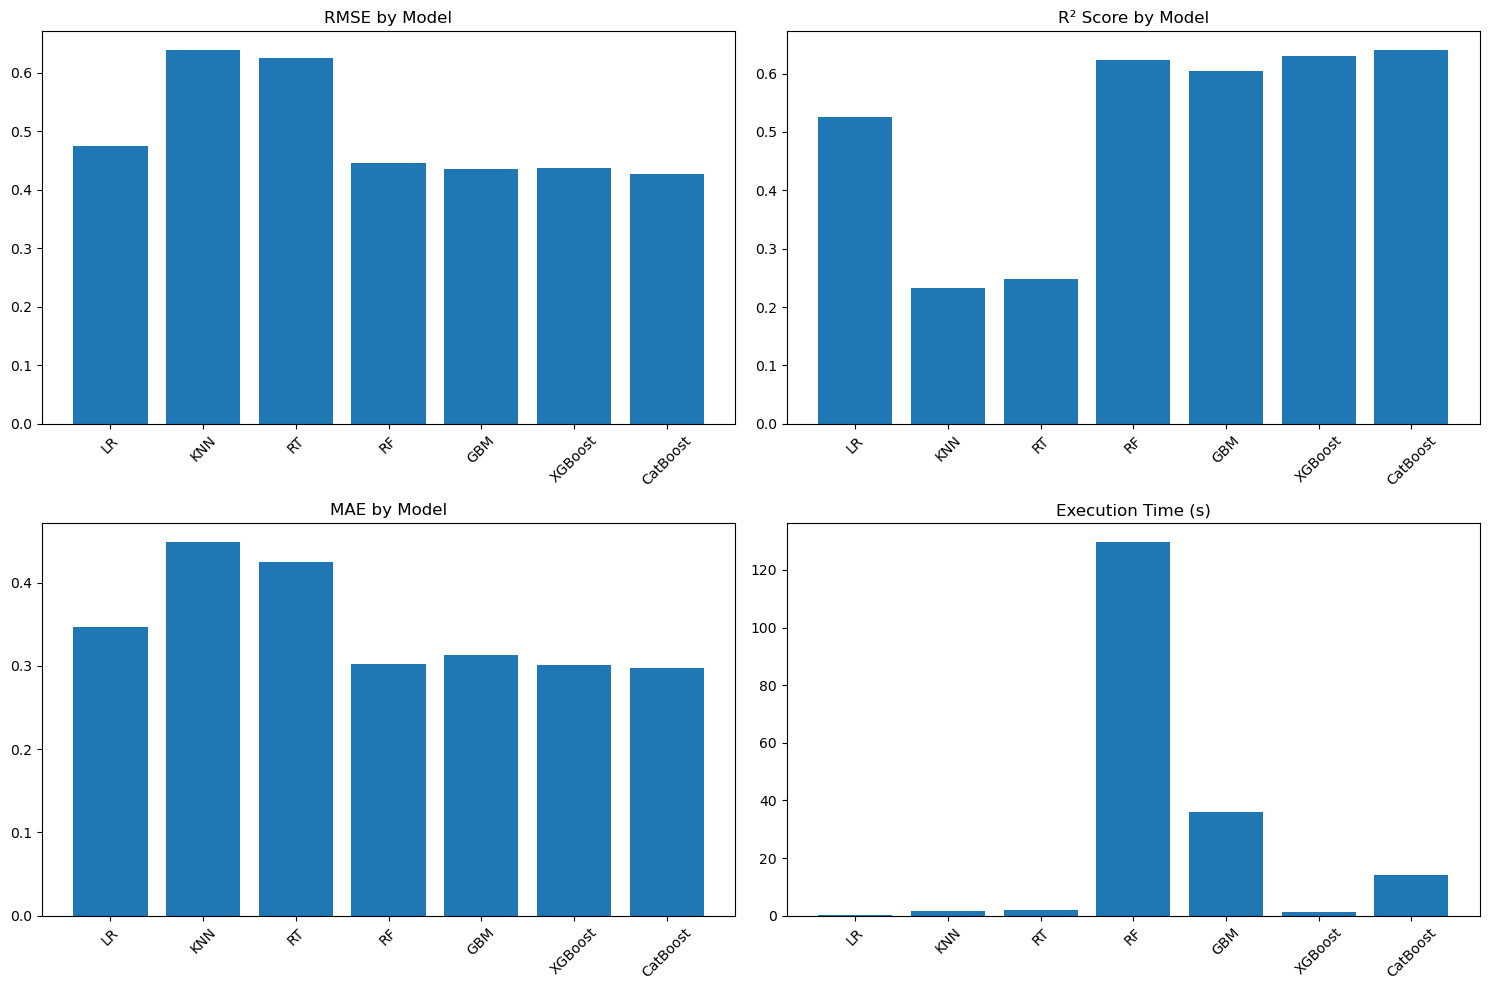


=== LR Analysis ===
RMSE: 0.4759
R² Score: 0.5250
MAE: 0.3464
Execution Time: 0.35s

Learning Curves:


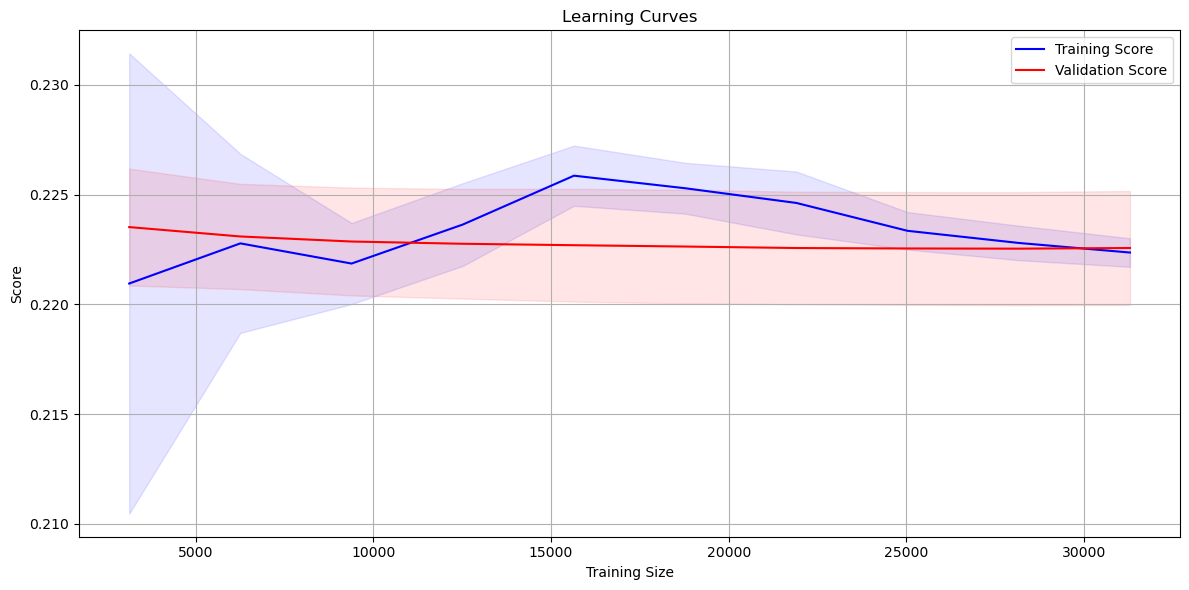


Residual Analysis:


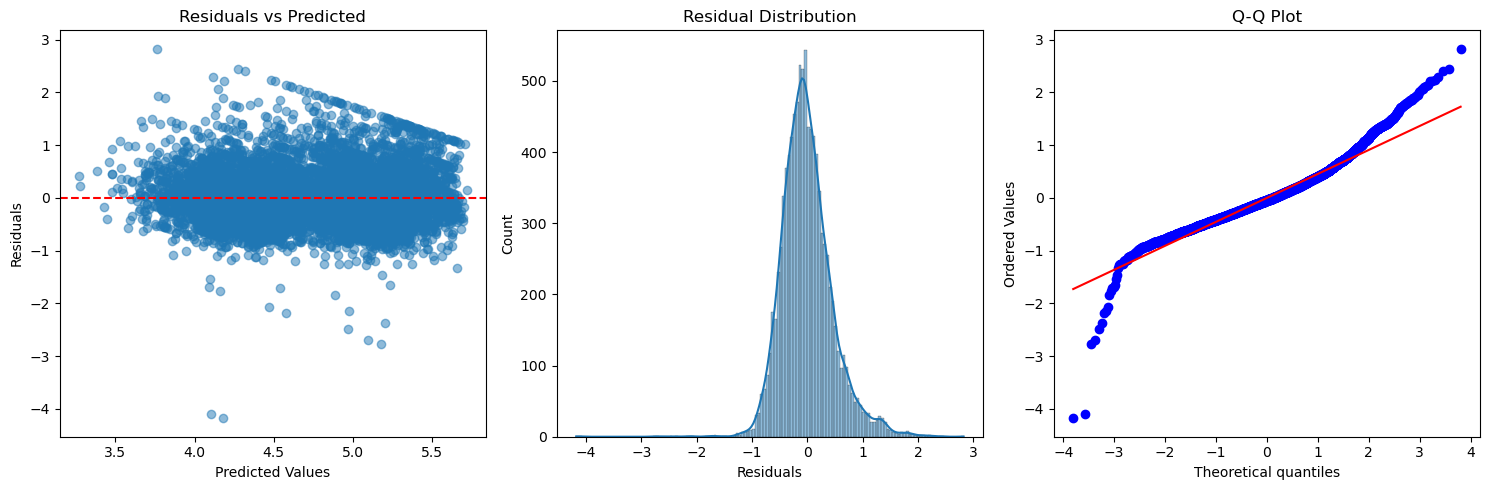


Prediction Error Analysis:



=== KNN Analysis ===
RMSE: 0.6392
R² Score: 0.2318
MAE: 0.4488
Execution Time: 1.48s

Learning Curves:


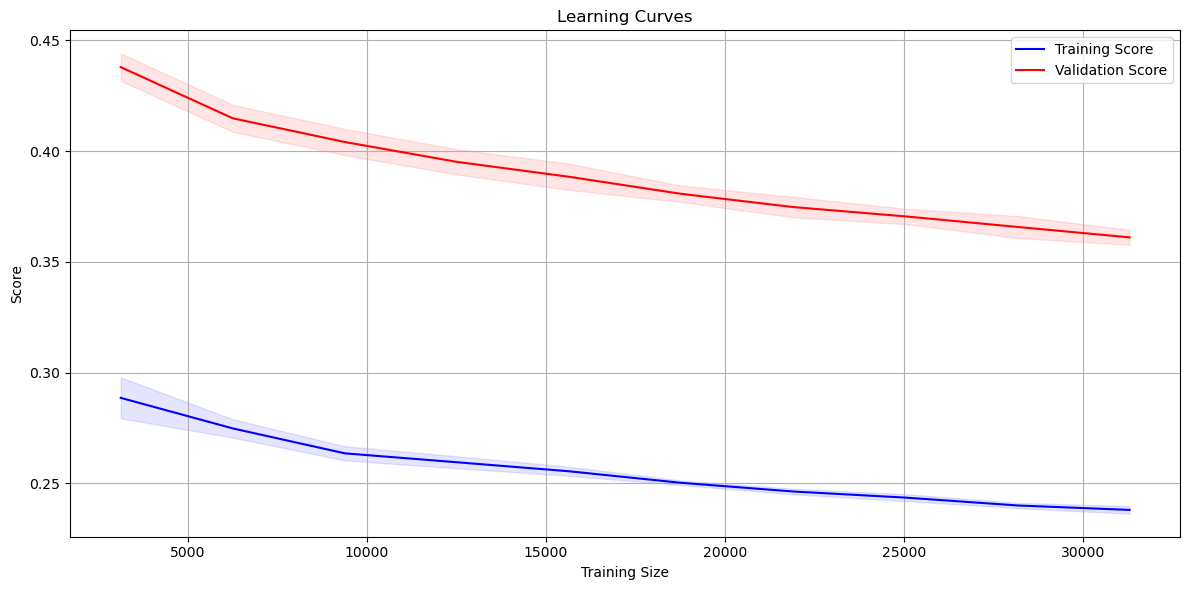


Residual Analysis:


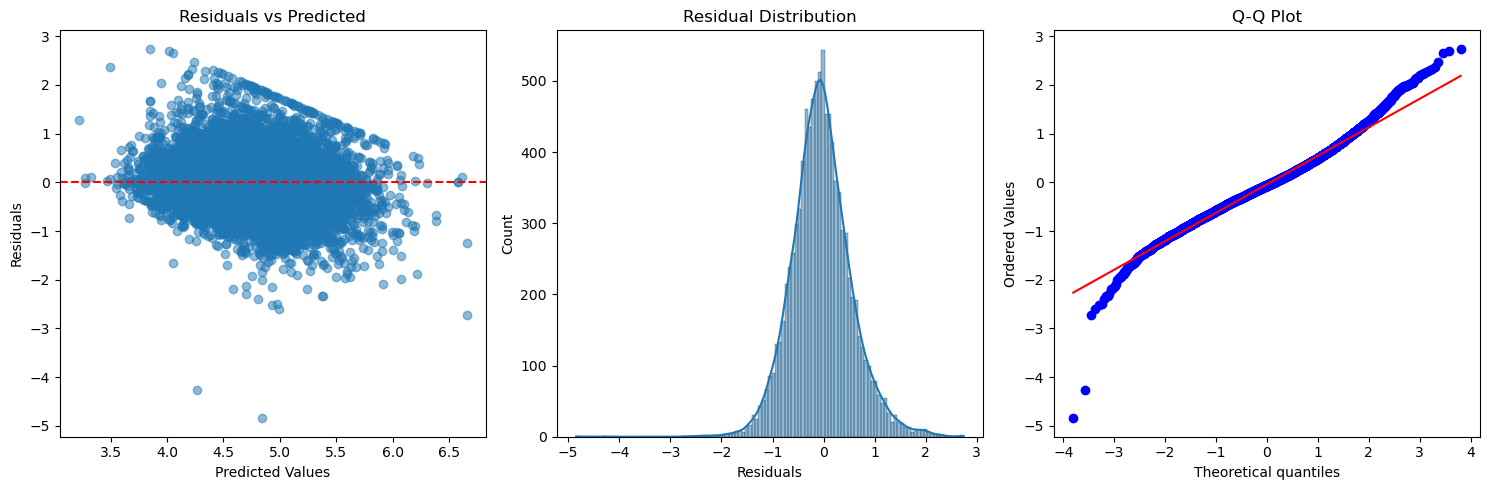


Prediction Error Analysis:



=== RT Analysis ===
RMSE: 0.6261
R² Score: 0.2473
MAE: 0.4246
Execution Time: 2.10s

Learning Curves:


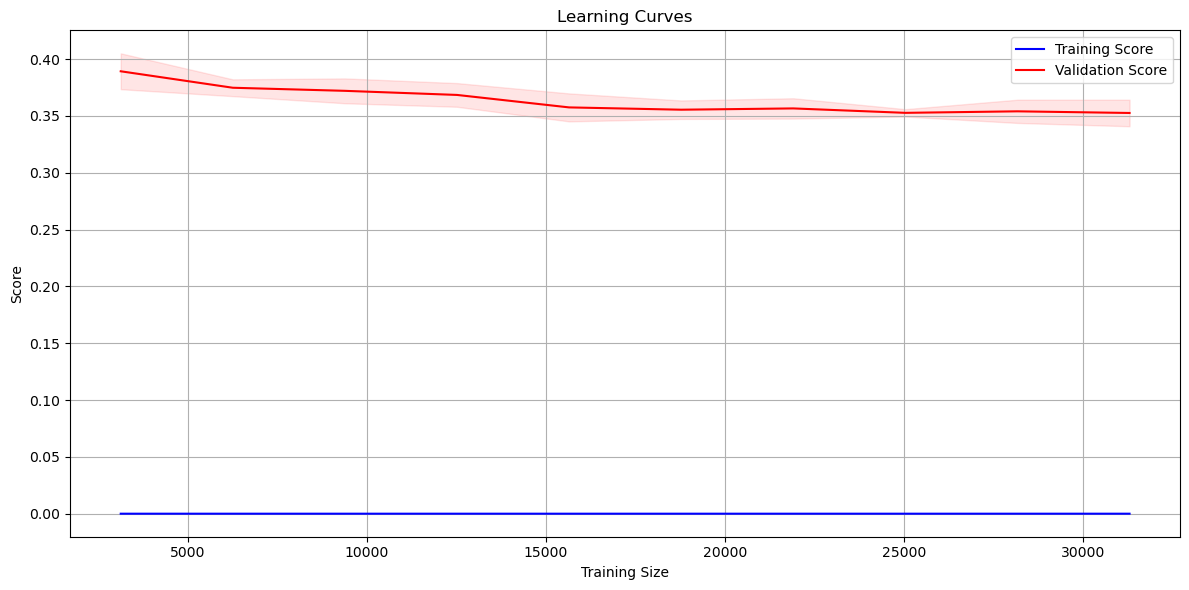


Residual Analysis:


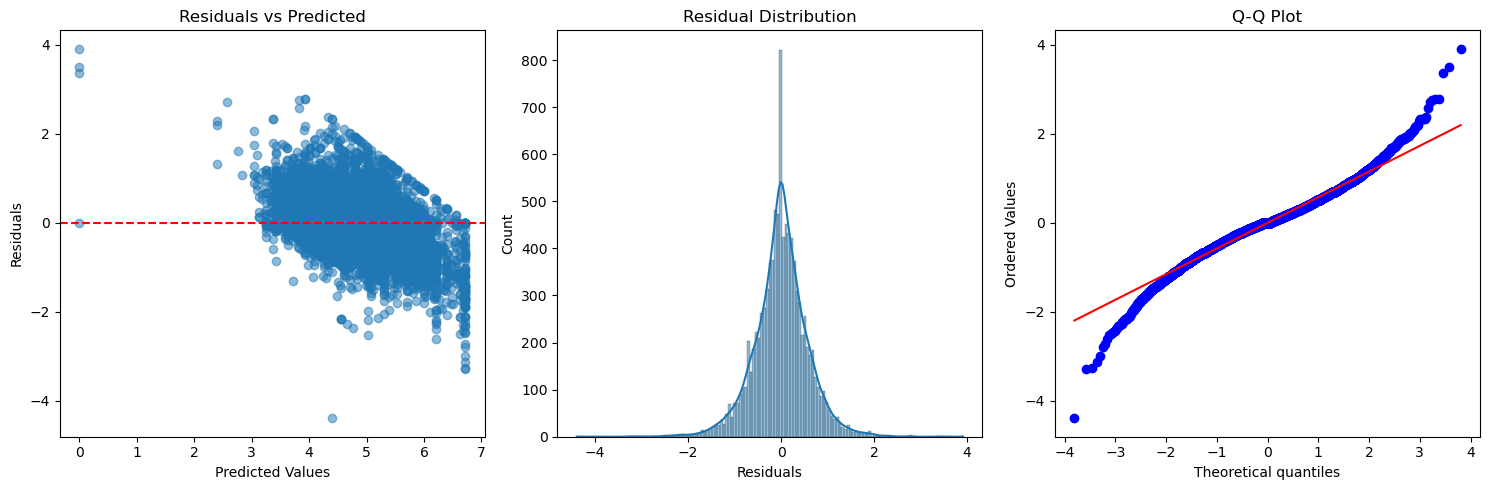


Prediction Error Analysis:



=== RF Analysis ===
RMSE: 0.4458
R² Score: 0.6232
MAE: 0.3018
Execution Time: 129.68s

Learning Curves:


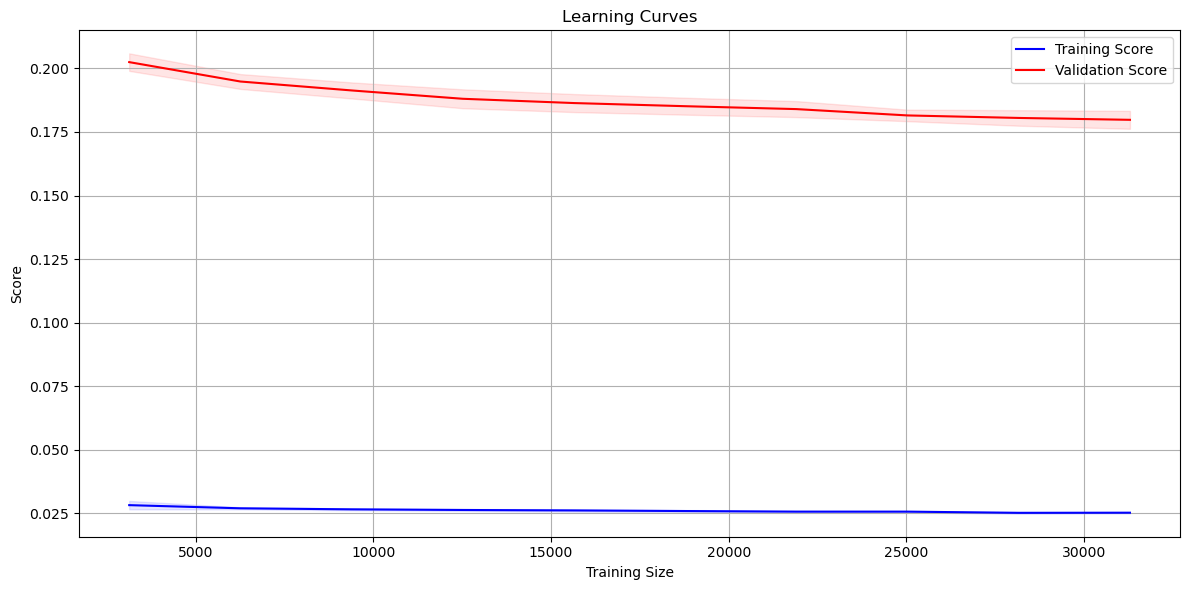


Residual Analysis:


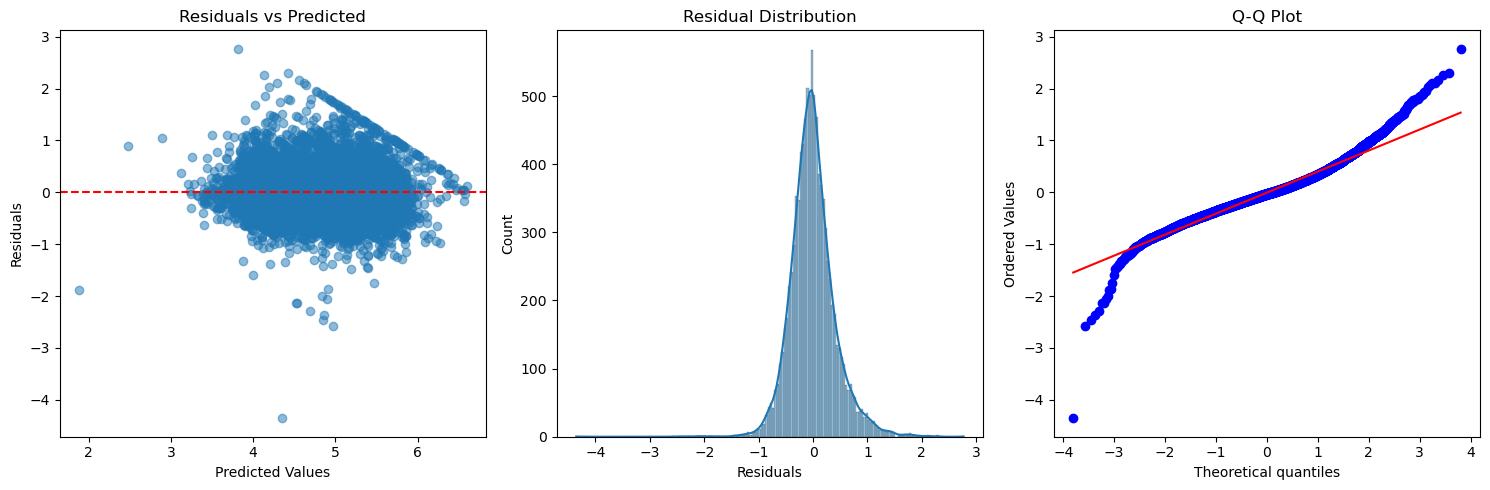


Prediction Error Analysis:



=== GBM Analysis ===
RMSE: 0.4365
R² Score: 0.6035
MAE: 0.3129
Execution Time: 35.86s

Learning Curves:


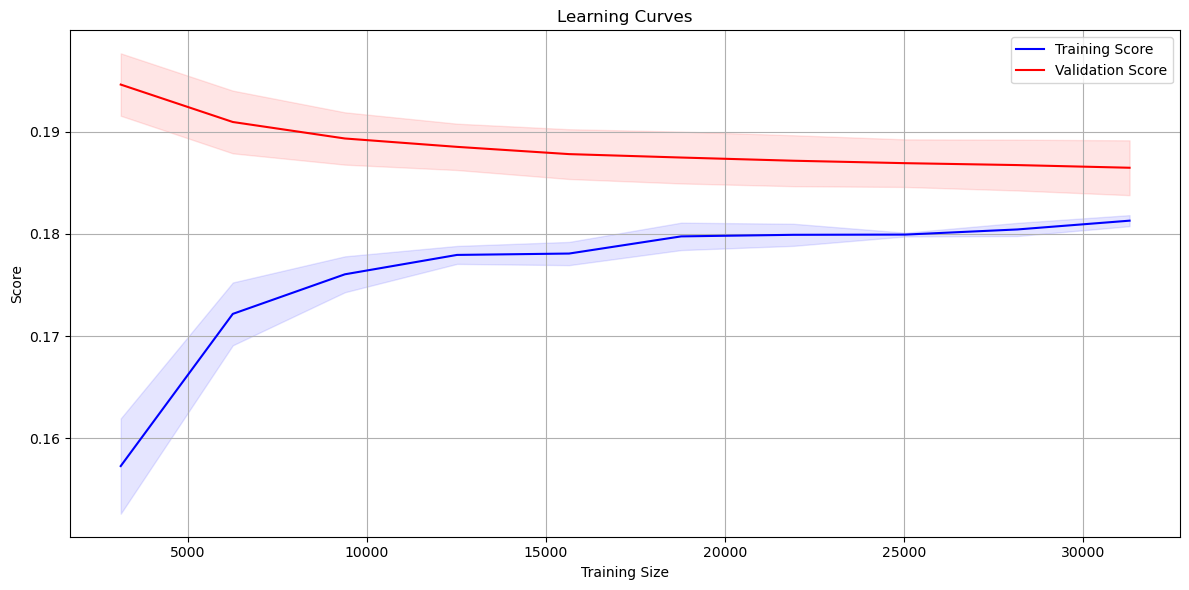


Residual Analysis:


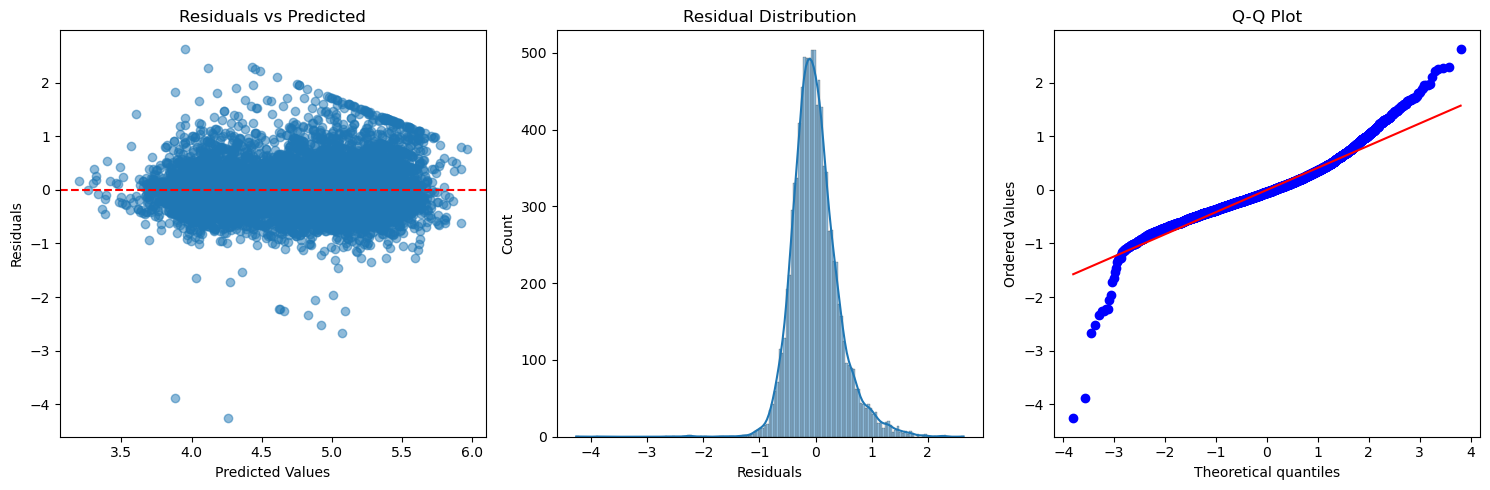


Prediction Error Analysis:



=== XGBoost Analysis ===
RMSE: 0.4374
R² Score: 0.6306
MAE: 0.3014
Execution Time: 1.25s

Learning Curves:


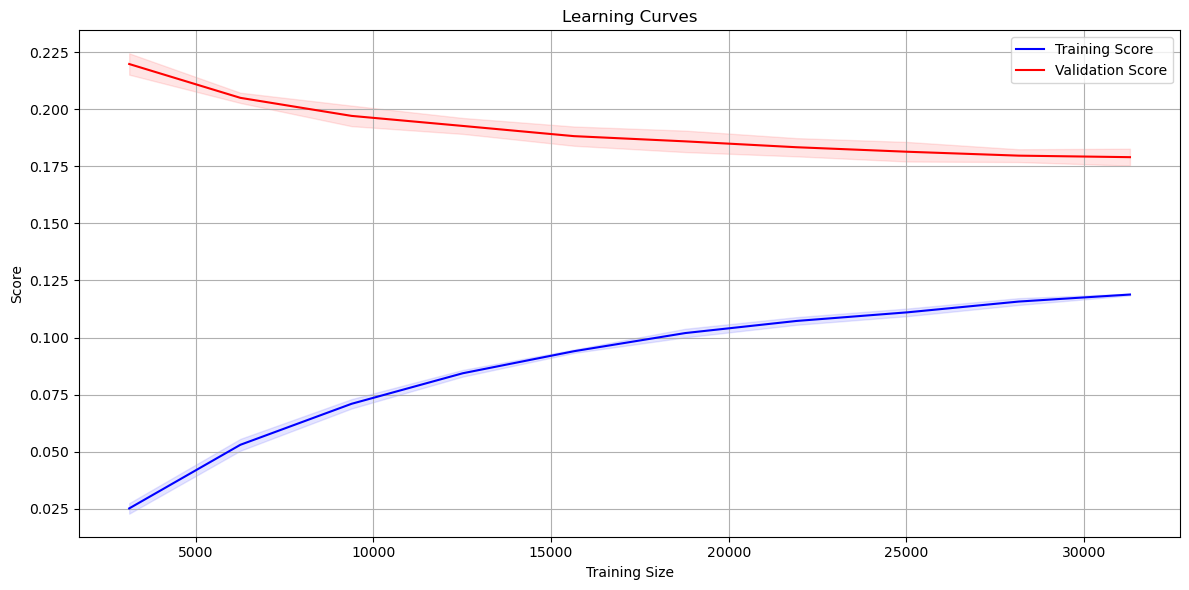


Residual Analysis:


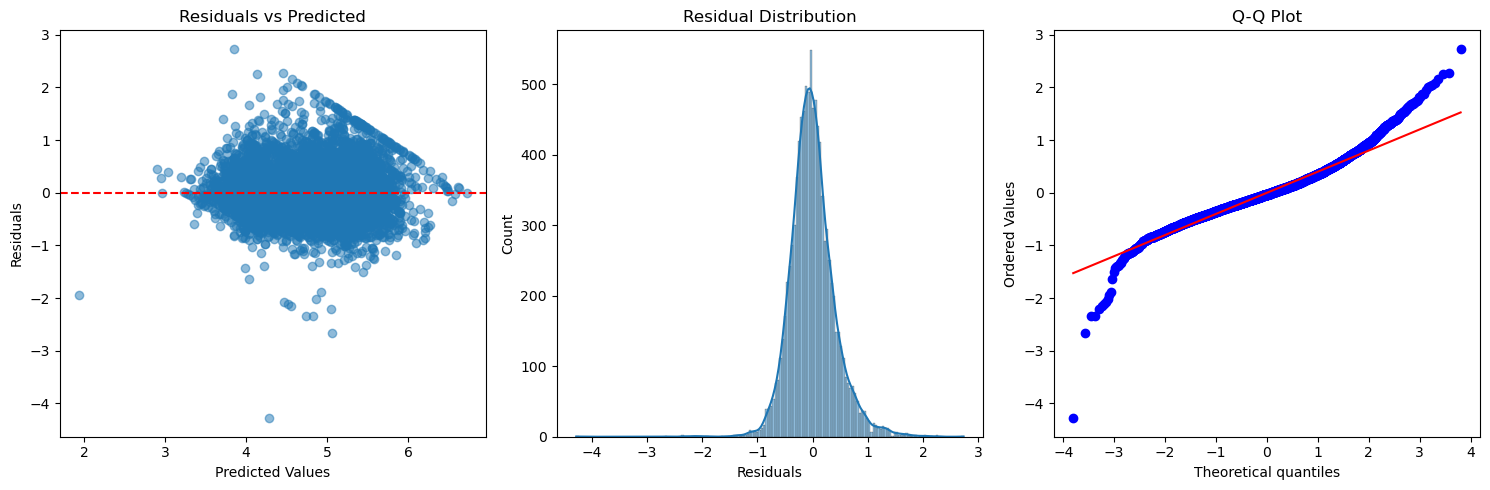


Prediction Error Analysis:



=== CatBoost Analysis ===
RMSE: 0.4270
R² Score: 0.6403
MAE: 0.2969
Execution Time: 14.24s

Learning Curves:


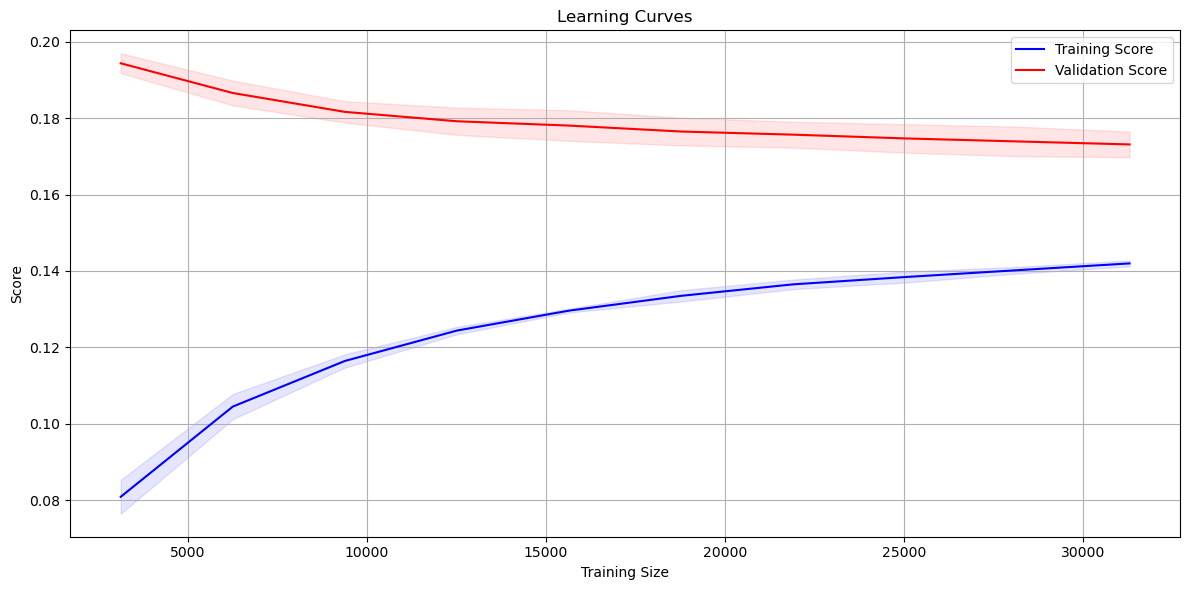


Residual Analysis:


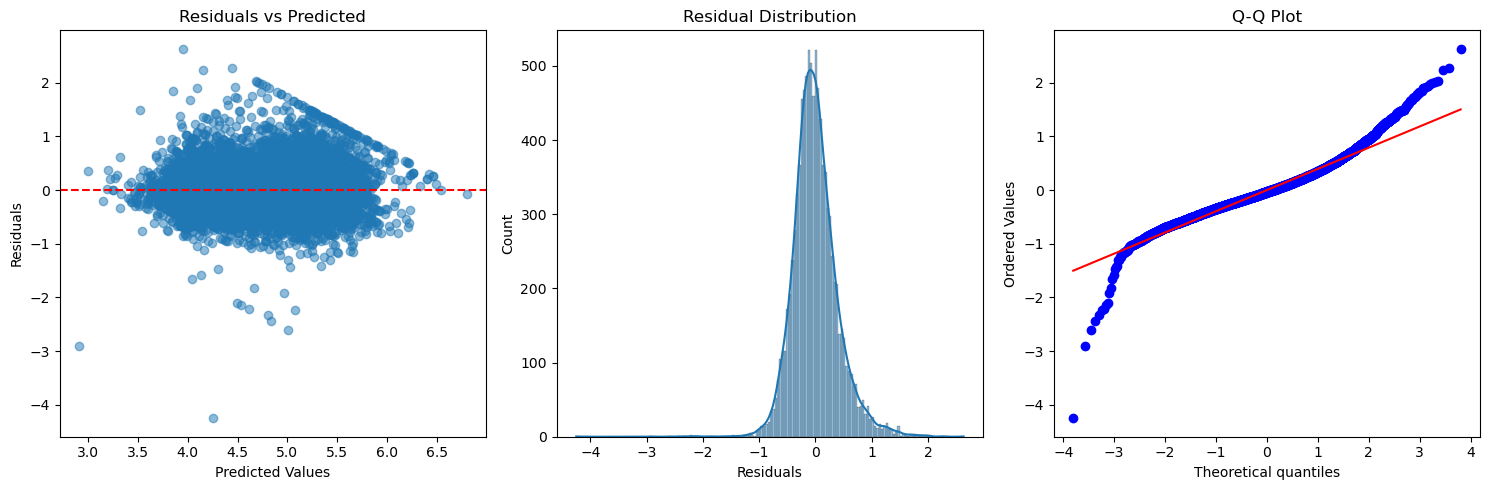


Prediction Error Analysis:




In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_metrics_comparison(models, rmse_scores, r2_scores, mae_scores, execution_times):
    """
    Create a summary plot comparing key metrics across models
    """
    model_names = [model[0] for model in models]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # RMSE Plot
    axes[0, 0].bar(model_names, rmse_scores)
    axes[0, 0].set_title('RMSE by Model')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # R² Plot
    axes[0, 1].bar(model_names, r2_scores)
    axes[0, 1].set_title('R² Score by Model')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # MAE Plot
    axes[1, 0].bar(model_names, mae_scores)
    axes[1, 0].set_title('MAE by Model')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Time Plot
    axes[1, 1].bar(model_names, execution_times)
    axes[1, 1].set_title('Execution Time (s)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def analyze_models(models, X_train, X_test, y_train, y_test, feature_names, 
                  rmse_scores, r2_scores, mae_scores, execution_times):
    """
    Create comprehensive analysis using the provided plotting functions
    """
    # First plot the overall metrics comparison
    plot_metrics_comparison(models, rmse_scores, r2_scores, mae_scores, execution_times)
    
    # Analyze each model individually
    for (name, model), rmse, r2, mae, exec_time in zip(models, rmse_scores, r2_scores, 
                                                      mae_scores, execution_times):
        print(f"\n=== {name} Analysis ===")
        print(f"RMSE: {rmse:.4f}")
        print(f"R² Score: {r2:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"Execution Time: {exec_time:.2f}s")
        
        # Plot learning curves using the provided function
        print("\nLearning Curves:")
        plot_learning_curves(model, X_train, y_train)
        plt.show()
        
        # Try to plot feature importance if the model supports it
        #print("\nFeature Importance:")
        #try:
        #    plot_feature_importance(model, feature_names)
        #    plt.show()
        #except:
        #    print(f"Feature importance not available for {name}")
        
        # Make predictions and plot residuals
        y_pred = model.predict(X_test)
        print("\nResidual Analysis:")
        plot_residuals(y_test, y_pred)
        plt.show()
        
        # Plot prediction error
        print("\nPrediction Error Analysis:")
        plot_prediction_error(y_test, y_pred)
        plt.show()
        
        print("\n" + "="*50 + "\n")


analyze_models(models, X_train, X_test, y_train, y_test, X.columns,
              rmse_scores, r2_scores, mae_scores, execution_times)

In [16]:
# Initialize the models
# Models that performed poorly in previous steps were removed 
# (Random Forrest takes significantly longer as other similarly performant models)

models = [('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("CatBoost", CatBoostRegressor(verbose=False))]

# Initialize lists to store metrics
rmse_scores = []
r2_scores = []
r2_adj_scores = []
mae_scores = []
mse_scores = []
execution_times = []

# Define the hyperparameters for each model
param_grids = {
    'GBM': {'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.15, 0.2]},
    'XGBoost': {'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.15, 0.2]},
    'CatBoost': {'iterations': [100, 200, 300], 'learning_rate': [0.1, 0.15, 0.2], 'depth': [4, 6]}
}

# Train and evaluate the models with hyperparameter tuning
for name, regressor in models:
    print(f"Hyperparameter Tuning for {name}:")
    start_time = time.time()

    if param_grids[name]:
        grid_search = GridSearchCV(regressor, param_grid=param_grids[name], cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

        print(f"Best parameters: {grid_search.best_params_}")
    else:
        best_model = regressor.fit(X_train, y_train)

    # Make
    y_pred = best_model.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

    # Calculate R^2 score
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

    # Calculate R^2 Adj score
    r2_adj = adjusted_r2(y_test, y_pred, len(X_train), len(X_train.columns))
    r2_adj_scores.append(r2_adj)

    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

    # Calculate MSE
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

    # Calculate the execution time of the model
    execution_time = time.time() - start_time
    execution_times.append(execution_time)

    print(f"RMSE: {round(rmse, 4)} ({name})")
    print(f"R^2 Score: {round(r2, 4)} ({name})")
    print(f"Adjusted R^2: {round(r2_adj, 4)} ({name})")
    print(f"MAE: {round(mae, 4)} ({name})")
    print(f"MSE: {round(mse, 4)} ({name})")
    print(f"Execution Time: {round(execution_time, 2)} seconds\n")

Hyperparameter Tuning for GBM:
Best parameters: {'learning_rate': 0.15, 'n_estimators': 300}
RMSE: 0.4151 (GBM)
R^2 Score: 0.6201 (GBM)
Adjusted R^2: 0.62 (GBM)
MAE: 0.3059 (GBM)
MSE: 0.1723 (GBM)
Execution Time: 77.25 seconds

Hyperparameter Tuning for XGBoost:
Best parameters: {'learning_rate': 0.1, 'n_estimators': 300}
RMSE: 0.4056 (XGBoost)
R^2 Score: 0.6373 (XGBoost)
Adjusted R^2: 0.6371 (XGBoost)
MAE: 0.2978 (XGBoost)
MSE: 0.1645 (XGBoost)
Execution Time: 4.16 seconds

Hyperparameter Tuning for CatBoost:
Best parameters: {'depth': 6, 'iterations': 300, 'learning_rate': 0.2}
RMSE: 0.4056 (CatBoost)
R^2 Score: 0.6373 (CatBoost)
Adjusted R^2: 0.6372 (CatBoost)
MAE: 0.298 (CatBoost)
MSE: 0.1645 (CatBoost)
Execution Time: 12.77 seconds



In [17]:
# Final Prediction Model
final_model = best_model

# Make predictions on the test set using the final model
y_final_pred = final_model.predict(X_test)
final_y_pred = (y_final_pred)
final_y_test =(y_test)

In [18]:
# Create a DataFrame with the predicted prices and true prices
results = pd.DataFrame({'Predicted Price': final_y_pred, 'True Price': final_y_test})

# Calculate the difference between the true prices and predicted prices and add a new column
results['Difference'] = results['True Price'] - results['Predicted Price']

# Display the results
print(results)

       Predicted Price  True Price  Difference
879           4.771988    4.499810   -0.272179
44383         3.886540    3.433987   -0.452553
15394         4.672660    4.795791    0.123131
43230         5.733072    6.154858    0.421786
16332         4.909658    5.298317    0.388660
...                ...         ...         ...
20477         5.490349    5.375278   -0.115071
44969         5.212294    4.615121   -0.597174
36577         4.025201    4.262680    0.237479
11477         5.309199    6.216606    0.907407
1023          5.126543    4.836282   -0.290261

[9779 rows x 3 columns]


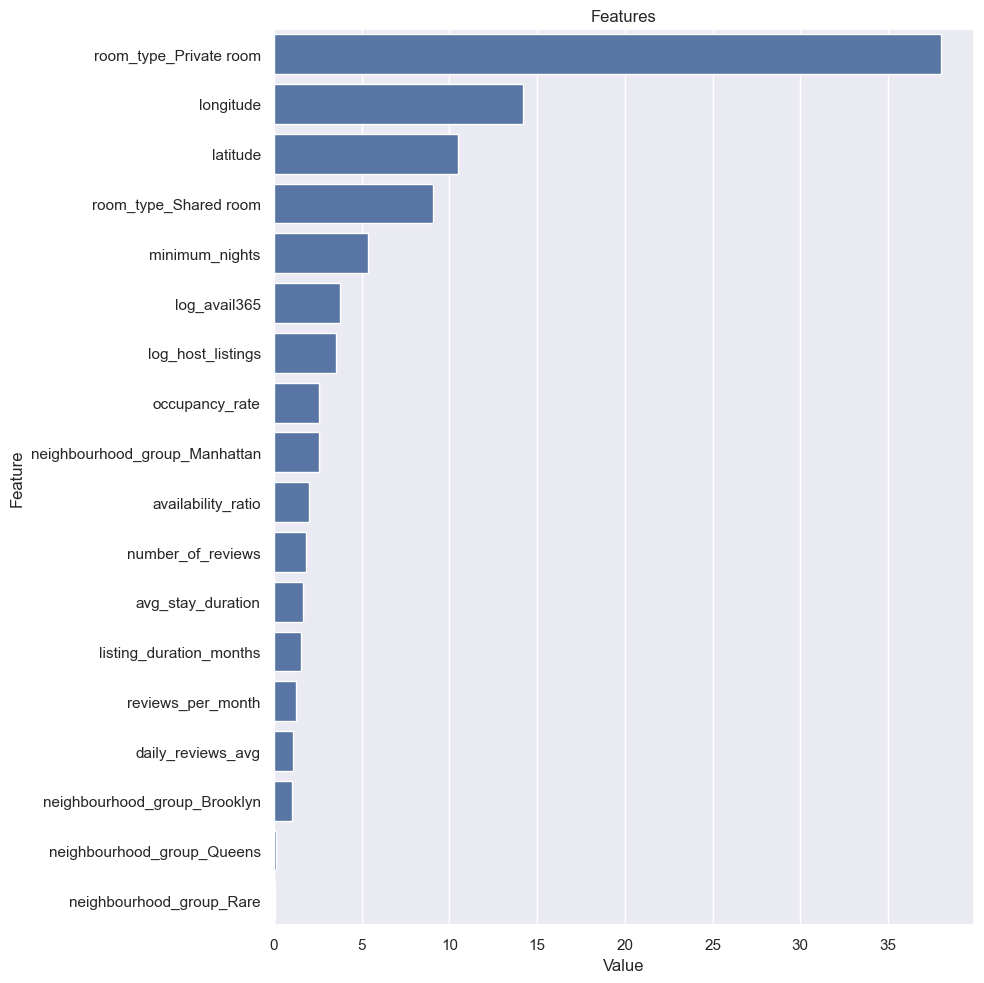

In [19]:
def plot_importance(model, features, num=50, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig('importances.png')

plot_importance(final_model, X)